# Time series anomaly detection using Autoencoder
## Analysis of the Algorithm
### Author: [pavithrasv](https://github.com/pavithrasv)
### Second Author: [Zahangir](https://github.com/cs-joy)

In [ ]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import keras
from keras import layers
import matplotlib.pyplot as plt

### Load data

Here is the data [source](https://github.com/numenta/NAB/tree/master/data) which we will use as our dataset.

and here is the kaggle source of the dataset: [kaggle](https://www.kaggle.com/datasets/boltzmannbrain/nab)

***About dataset: *** The Numenta Anomaly Benchmark (NAB) is a novel benchmark for evaluating algorithms for anomaly detection in streaming, online applications. It is comprised of over 50 labeled real-world and artificial timeseries data files plus a novel scoring mechanism designed for real-time applications. All of the data and code is fully open-source, with extensive documentation, and a scoreboard of anomaly detection algorithms: [github.com/numenta/NAB](https://github.com/numenta/NAB). The full dataset is included here, but please go to the repo for details on how to evaluate anomaly detection algorithms on NAB.


Note: We will use `art_daily_small_noise.csv` file for training and `art_daily_jumpsup.csv` file for testing. Through the following dataset we can detect anomaly effectively.

In [ ]:
data_source = "https://raw.githubusercontent.com/numenta/NAB/master/data/";
data_location = "artificialNoAnomaly/art_daily_small_noise.csv";
df_small_noise = pd.read_csv(
    data_source+data_location, parse_dates=True, index_col="timestamp"
)

data_location = "artificialWithAnomaly/art_daily_jumpsup.csv";
df_daily_jumpsup = pd.read_csv(
    data_source + data_location, parse_dates=True, index_col="timestamp"
)

print(df_small_noise.head())
print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


### Visualize the data

#### Timeseries data without anomalies

Following data will use as our training set

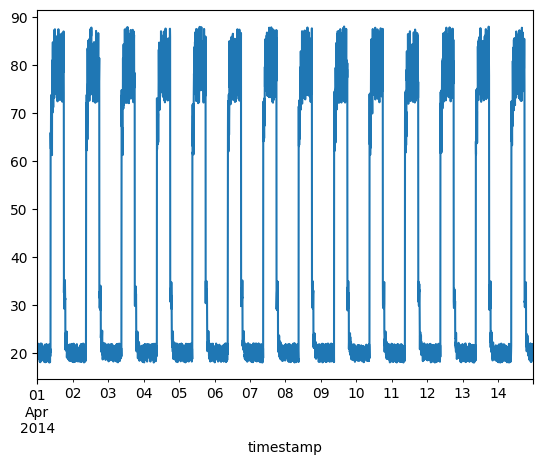

In [ ]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

and the following dataset will use as our testing set

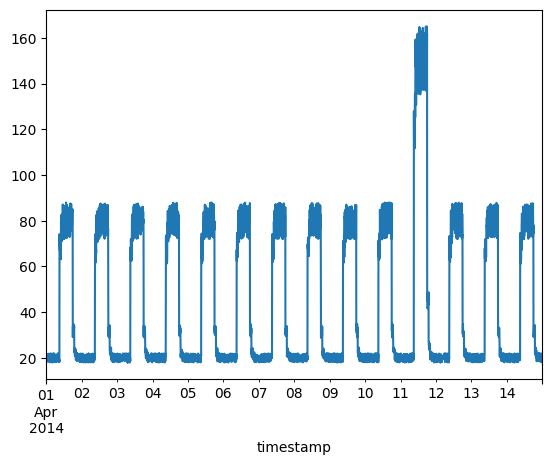

In [ ]:
fix, ax = plt.subplots()
df_daily_jumpsup.plot(legend= False, ax=ax)
plt.show()

### Preparing the traing data
We have a `value` for every 5 mins for 14 days.
So,
- 24 * 60 / 5 = **288 timestamps** per day
- 288 * 14 = **4032 data points** in total

In [ ]:
len(df_small_noise)

4032

In [ ]:
## Normalize and save the mean and standard deviation we get
# z-score normalization -> z = /frac{x - mu}{sigma}; where, x = data(original value), mu = mean of the data and sigma is std(standard deviation) of the data
#############
'''
# Why Standardize data?
1. Centering the data
  1.1 Subtracting the mean to shifts the data distribution to be centered around 0.
  1.2 Gradient descent converges faster, because it helps to remove biases from the data.
2. Scaling to unit variance (std=1)
  2.1 Dividing by the std ensures that all features have the same scale(variance=1).
  2.2 Prevents features with larger magnitudes from dominating those with smaller magnitudes.
3. Improves models performance
4. Speed Up Training
5. Handling Outliers.

note: tree based models (random forest, XGBoost) don't require standardization because they split data based on relative values instead of distances.
'''


training_mean = df_small_noise.mean()
training_std = df_small_noise.std()

df_training_value = (df_small_noise - training_mean) / training_std;
print(f'Number of training samples: {len(df_training_value)}');

Number of training samples: 4032


### Create Sequence
Create sequence combining `TIME_STEPS` contigiuous data values from the training data

In [ ]:
TIME_STEPS = 288

# generating training sequence here
def create_sequence(values, time_steps=TIME_STEPS):
  #print(f'length of values: {len(values)}')
  output = []
  for i in range(len(values) - time_steps + 1):
    print(f'values[i:(i+time_steps)]: {values[i:(i+time_steps)]}')
    output.append(values[i:(i+time_steps)])

  return np.stack(output) # https://numpy.org/devdocs/reference/generated/numpy.stack.html

In [ ]:
X_train = create_sequence(df_training_value.values, TIME_STEPS)
print(f'Training input shape: {X_train.shape}')

Streaming output truncated to the last 5000 lines.
 [ 1.27008881]
 [ 1.13302139]
 [ 1.40886273]
 [ 1.46808347]
 [ 1.58378335]
 [ 1.21166005]
 [ 1.59421039]
 [ 1.08879908]
 [ 1.39636637]
 [ 1.08530604]
 [ 1.5620508 ]
 [ 1.35465196]
 [ 1.43427898]
 [ 1.52672379]
 [ 1.13850351]
 [ 1.07484001]
 [ 1.55368198]
 [ 1.23231428]
 [ 1.12634756]
 [ 1.31980275]
 [ 1.39379529]
 [ 1.07049718]
 [ 1.20949873]
 [ 1.0715396 ]
 [ 1.2923996 ]
 [ 1.56294797]
 [ 1.61284039]
 [ 1.41589474]
 [ 1.14497869]
 [ 1.56907358]
 [ 1.34705606]
 [ 1.14048343]
 [ 1.57812137]
 [ 1.48451788]
 [ 1.46983619]
 [ 1.45700038]
 [ 1.16703751]
 [ 1.17311612]
 [ 1.4451019 ]
 [ 1.17808304]
 [ 1.30285302]
 [ 1.4985027 ]
 [ 1.49961431]
 [ 1.3111673 ]
 [ 1.50430848]
 [ 1.53076808]
 [ 1.4260018 ]
 [ 1.18304258]
 [-0.42328711]
 [-0.41398031]
 [-0.45912158]
 [-0.42348135]
 [-0.43798777]
 [-0.38195707]
 [-0.27867385]
 [-0.46193071]
 [-0.3215659 ]
 [-0.3290846 ]
 [-0.46391977]
 [-0.2754519 ]
 [-0.7027643 ]
 [-0.73543378]
 [-0.67275633]
 [-0

# Build model

Here we will build `Convolutional Recontruction AutoEncoder Model`. The model will take input of shape `(batch_size, sequence_length, num_features)`and return output of the same shape. In this case, `sequence_length` is 288 and `number_features` is 1.

In [ ]:
# padding and strided convolutions, that offer more control over the size of the output.

CRA_model = keras.Sequential(
    [
        layers.Input(shape=[X_train.shape[1], X_train.shape[2]]),
        layers.Conv1D(
            filters = 32,
            kernel_size = 7,
            padding = "same",
            strides = 2,
            activation = "relu"
        ),
        layers.Dropout(rate= 0.2),
        layers.Conv1D(
            filters = 16,
            kernel_size = 7,
            padding = "same",
            strides = 2,
            activation = "relu"
        ),
        layers.Conv1DTranspose(
            filters = 16,
            kernel_size = 7,
            padding = "same",
            strides = 2,
            activation = "relu"
        ),
        layers.Dropout(rate= 0.2),
        layers.Conv1DTranspose(
            filters = 32,
            kernel_size = 7,
            padding = "same",
            strides = 2,
            activation = "relu"
        ),
        layers.Conv1DTranspose(
            filters = 1,
            kernel_size = 7,
            padding = "same"
        )
    ]
)

CRA_model.compile(optimizer=keras.optimizers.Adam(learning_rate= 0.01), loss="mse")
CRA_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 144, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 144, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 72, 16)         │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 144, 16)        │         1,808 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 144, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 288, 32)        │         3,616 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 288, 1)         │           225 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,505 (37.13 KB)

 Trainable params: 9,505 (37.13 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model
We are using `X_train` as both the input and target, since this a reconstruction model.

In [12]:
trained_CRA_model = CRA_model.fit(
    X_train,
    X_train,
    epochs = 50,
    batch_size = 128,
    validation_split = 0.1,
    callbacks = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5, mode = "min")
    ]
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.4396 - val_loss: 0.0391
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0482 - val_loss: 0.0235
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0307 - val_loss: 0.0167
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0251 - val_loss: 0.0157
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0217 - val_loss: 0.0178
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0192 - val_loss: 0.0164
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0175 - val_loss: 0.0150
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0164 - val_loss: 0.0163
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0154 - val_loss: 0.0228
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0146 - val_loss: 0.0189
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0133 - val_loss: 0.0164
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0

### Plot Training and Valdation Loss

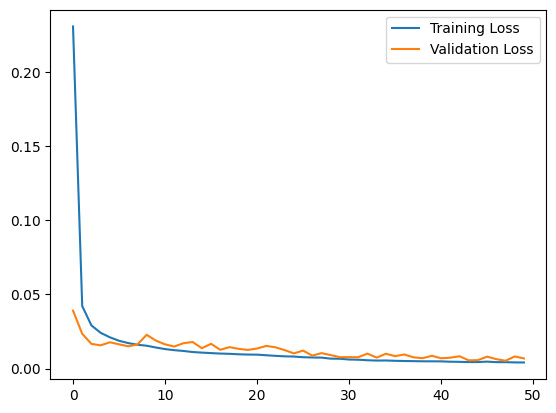

In [13]:
plt.plot(trained_CRA_model.history["loss"], label="Training Loss")
plt.plot(trained_CRA_model.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

### Detecting Anomalies
Detect anomalies by determining how well `trained_CRA_model` can reconstruct the input data.

1. Find MAE loss on training samples.
2. Find maximum MAE loss value. This is the worst our model has performed trying reconstruct a sample. We will make this the `threshold` for anomaly detection.
3. If the reconstruction loss for a sample is greater than the `threshold` then we can infer that the model is seeing a pattern that it isn't familier with and then we will label the sample as an `anomaly`.

That's our main purposes.

In [15]:
# calculate train MAE error
X_trained_pred = CRA_model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_trained_pred - X_train), axis=1)   # MAE = 1/n * summation_i=1<->n( |predcted_value_i - original value_i|)

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


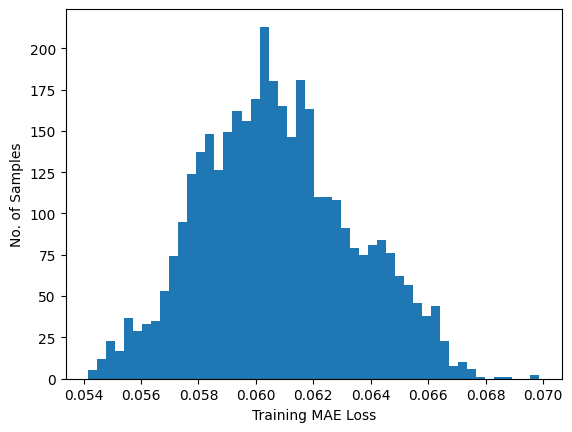

In [16]:
# visualize the result
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Training MAE Loss")
plt.ylabel("No. of Samples")
plt.show()

In [17]:
# calculate reconstruction loss threshold
threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

Reconstruction error threshold: 0.06986096426421948


### Compare recoonstruction
let's see how our `CRA_model` has reconstructed the first sample (288 timestamp that mean day 1 of our training set).

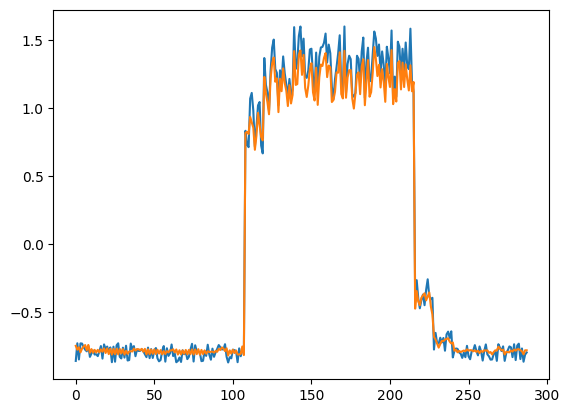

In [18]:
# Visualize how the first sequence is learnt
plt.plot(X_train[0])
plt.plot(X_trained_pred[0])
plt.show()